# Estimation of continuous variables with regression using _ImaGene_

In this example, the aim is to estimate a continuous parameter using regression.
Please refer to the tutorial for binary and multiclass classification for an in-depth explanation of each step and case study, and to the tutorial for multiclass classification on continuous variables for data generation and processing.

In this tutorial you will be utilising a GPU which will help speed up the training process. To enable the GPU, you need to go to...<br>
> Runtime >> Change runtime type >> select GPU as a hardware accelerator.


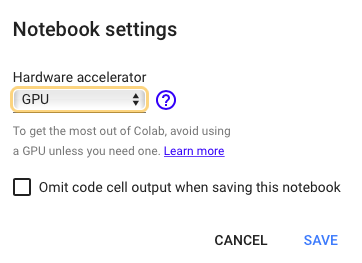

**Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/') #Follow the link, copy and paste the verification code, and press Enter 

Mounted at /content/drive/


In [ ]:
!ln -s "/content/drive/My Drive" /gdrive #Create a symbolic link to the drive. The path to the drive is now "/gdrive".

**Check if GPU is working** 

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name() #If GPU is enabled, the output will be '/device:GPU:0'

'/device:GPU:0'

In [ ]:
!python --version #Check if Python is version 3.6 which is compatible to Tensorflow2

Python 3.6.9


**Copy .vcf file and create a Continuous directory**

In [ ]:
!cp -R /gdrive/ImaGene/Tutorials/LCT.CEU.vcf /content #Copy the .vcf to the working directory 

In [ ]:
!mkdir /gdrive/ImaGene/Tutorials/Regression #Create "Regression" directory

In [ ]:
%tensorflow_version 2.x
import os
import gzip
import _pickle as pickle

import numpy as np
import scipy.stats
import pymc3

import tensorflow as tf
from tensorflow import keras
from keras import models, layers, activations, optimizers, regularizers
from keras.utils import plot_model
from keras.models import load_model

import skimage.transform
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pydot

In [ ]:
%run -i /gdrive/ImaGene/ImaGene.py

### 1. read data from VCF file and store it into _ImaGene_ objects

As an illustration, we double sort the image by ordering rows and columns by frequency. We also filter out singletons and do not resize. 

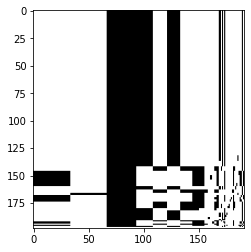

An object of 1 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000


0

In [ ]:
file_LCT = ImaFile(nr_samples=198, VCF_file_name='LCT.CEU.vcf')
gene_LCT = file_LCT.read_VCF()
gene_LCT.filter_freq(0.01)
gene_LCT.sort('rows_freq')
gene_LCT.sort('cols_freq')
gene_LCT.convert(flip=True)
gene_LCT.plot()
gene_LCT.summary()

### 2. run and process simulations to be used for training the neural network

In [ ]:
path = '/gdrive/ImaGene/Tutorials/' #Change path

See tutorial `03_multiclass_for_continuous`. Here I assume simulations are in `path+Continuous`.

### 3. implement, train and evaluate the neural network

The pipeline for training and testing is the following one.
We resize all images to match the real data.

In [ ]:
i = 1
while i <= 10:

    # simulations 
    file_sim = ImaFile(simulations_folder=path+'Continuous/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')

    # retain only 20 data points per class as a quick example
    gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=3)
    
    # manipulate data
    gene_sim.filter_freq(0.01)
    gene_sim.sort('rows_freq')
    gene_sim.sort('cols_freq')
    gene_sim.resize((198, int(gene_LCT.dimensions[1][0])))
    gene_sim.convert(flip=True)
    
    # randomise data
    gene_sim.subset(get_index_random(gene_sim))
 
    # at first iteration we build the model 
    # noe that the last layer has a linear activation function
    if i == 1:

        model = models.Sequential([
                    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid', input_shape=gene_sim.data.shape[1:]),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Flatten(),
                    layers.Dense(units=1)])
        model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

        net_LCT = ImaNet(name='[C32+P]+[C64+P]+[C128+P]')

    # training for iterations from 1 to 9
    print(i)
    if i < 10:
        score = model.fit(gene_sim.data, gene_sim.targets, batch_size=32, epochs=1, verbose=1, validation_split=0.10)
        net_LCT.update_scores(score)
    else:
        # testing for iteration 10
        net_LCT.test = model.evaluate(gene_sim.data, gene_sim.targets, batch_size=None, verbose=1)
        net_LCT.predict(gene_sim, model)

    i += 1

1
34/34 [==============================] - 2s 48ms/step - loss: 19862.5137 - mae: 118.6357 - val_loss: 22146.4785 - val_mae: 125.0373
2
34/34 [==============================] - 1s 37ms/step - loss: 15975.6973 - mae: 107.1254 - val_loss: 11021.0078 - val_mae: 88.0731
3
34/34 [==============================] - 1s 37ms/step - loss: 14415.9619 - mae: 101.0317 - val_loss: 10376.5664 - val_mae: 87.9347
4
34/34 [==============================] - 1s 37ms/step - loss: 10932.0449 - mae: 85.7086 - val_loss: 8847.0811 - val_mae: 78.3290
5
34/34 [==============================] - 1s 37ms/step - loss: 9408.1074 - mae: 78.3416 - val_loss: 10296.9883 - val_mae: 79.5365
6
34/34 [==============================] - 1s 37ms/step - loss: 8044.5239 - mae: 70.6551 - val_loss: 7251.4990 - val_mae: 67.2354
7
34/34 [==============================] - 1s 37ms/step - loss: 8384.5312 - mae: 72.5198 - val_loss: 6113.5415 - val_mae: 64.7327
8
34/34 [==============================] - 1s 38ms/step - loss: 8154.9521 - ma

In [ ]:
# save final (trained) model
model.save(path+'Data/model.cont.h5')
# save testing data
gene_sim.save(path+'Data/gene_sim.cont')
# save network
net_LCT.save(path+'Data/net_LCT.cont')

0

Recall that to load all these files you can use the following commands.

In [ ]:
gene_sim = load_imagene(path+'Data/gene_sim.cont')
net_LCT = load_imanet(path+'Data/net_LCT.cont')
model = load_model(path+'Data/model.cont.h5')

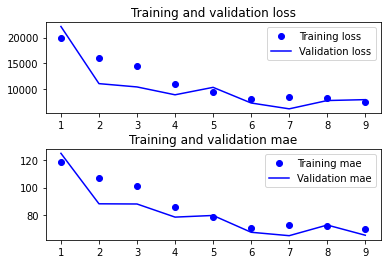

0

In [ ]:
# assess the training
net_LCT.plot_train()

In [ ]:
# print the testing results [loss, mae]
print(net_LCT.test)

[7381.03076171875, 64.88296508789062]


For the estimation of continuous variables, we can produce a scatter plot with `net.plot_scatter(MAP=False)`.

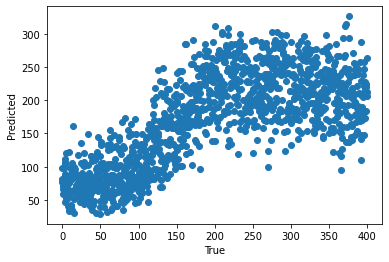

0

In [ ]:
net_LCT.plot_scatter(MAP=False)

### 4. deploy the trained network on your genomic data of interest

In [ ]:
model.predict(gene_LCT.data, batch_size=None)[0][0]

122.60657